The following code was used for extracting Galfit data, and the subsequent plotting and data visualization the Galfit data in conjunction with the UVISTA data.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
import sys
import os
from scipy.stats import binned_statistic
import re

In [2]:
# functions
def perc(arr):
	a = np.array(arr)
	p = np.percentile(a, 25)
	return p
def perc2(arr):
	a = np.array(arr)
	p = np.percentile(a, 75)
	return p
def perc3(arr):
    a = np.array(arr)
    p = np.percentile(a, 50)
    return p
    
def zeropad(n,zeros=4):
    "Pad number n with zeros. Example: zeropad(7,3) == '007'"
    nstr = str(n)
    while len(nstr) < zeros:
        nstr = "0" + nstr
    return nstr

In [3]:
#filelists
sex_seg = glob.glob('/Users/Nick/IS/Source_Extractor/Segmentation_Maps_crop/*.fits')
print len(sex_seg)
filefits = glob.glob('/Users/Nick/IS/HST_Images/Cropped/*.fits')
print len(filefits)
filegal = glob.glob('/Users/Nick/IS/Galfit/MC/Output2/*.fits')
print len(filegal)
SExCAT_all = glob.glob('/Users/Nick/IS/Source_Extractor/Catalog_crop/*')
sky_smooth = glob.glob('/Users/Nick/IS/Sky_Image/*')
ds = pd.read_csv('/Users/Nick/IS/Datasets/catalog8_USE+sigma_sky', delim_whitespace = True)
ds2 = pd.read_csv('/Users/Nick/IS/Datasets/catalog10_post_MC_Galfit2.csv', delim_whitespace = True, skiprows = 13)

3372
3372
3082


In [5]:
LMASS = ds2['LMASS']
jj = LMASS <9.5
print len(LMASS[jj])

1845


In [6]:
#updating dataset to be comprised of only galaxies modelling by galfit
idlst = []
for filen in filegal:
    string1 = filen
    id1 = [int(x.group()) for x in re.finditer(r'\d+', string1)]
    idlst.append(id1[2])
print len(idlst)
dsbool = ds['ID'].isin(idlst)

dsnew = ds[dsbool]
dsnew = dsnew.reset_index()
print len(dsnew)


3082
3082


In [12]:
#pulling data from galfit output
disk_re = []
bulge_re = []
disk_mag = []
bulge_mag = []
ba_ratiod = []
ba_ratiob = []
disk_pa = []
bulge_pa = []
for fcount in range (0, len(filegal)):
    galfit = fits.open(filegal[fcount])
    major_axis = galfit[2].header['1_RE'][0:5]
    if '*' in str(major_axis):
        major_axis = major_axis[1:5]
    disk_re.append(float(major_axis))
    
    major_axisb = galfit[2].header['2_RE'][0:5]
    if '*' in str(major_axisb):
        major_axisb = major_axisb[1:5]
    bulge_re.append(float(major_axisb))
    
    mag = galfit[2].header['1_MAG'][0:5]
    if '*' in str(mag):
        mag = mag[1:5]
    disk_mag.append(float(mag))
    
    magb = galfit[2].header['2_MAG'][0:5]
    if '*' in str(magb):
        magb = magb[1:5]
    bulge_mag.append(float(magb))
    
    ARd = galfit[2].header['1_AR'][0:10]
    if '*' in str(ARd):
        ARd = ARd[1:10]
    if 'e' not in str(ARd):
        ARd = ARd[0:6]
    ba_ratiod.append(float(ARd))
    
    ARb = galfit[2].header['2_AR'][0:10]
    if '*' in str(ARb):
        ARb = ARb[1:10]
    if 'e' not in str(ARb):
        ARb = ARb[0:6]
    ba_ratiob.append(float(ARb))
    
    PAd = galfit[2].header['1_PA'][0:5]
    if '*' in str(PAd):
        PAd = PAd[1:5]
    disk_pa.append(float(PAd))
    
    PAb = galfit[2].header['2_PA'][0:5]
    if '*' in str(PAb):
        PAb = PAb[1:5]
    bulge_pa.append(float(PAb))

In [ ]:
for fcount in range (0, len(filegal)):
    galfit = fits.open(filegal[fcount])
    ARd = galfit[2].header['2_AR'][0:10]
    if '*' in str(ARd):
        ARd = ARd[1:10]
    if 'e' not in str(ARd):
        ARd = ARd[0:6]
    #ba_ratiod.append(float(ARd))

In [ ]:
# initializing data lists
disk_re = []
bulge_re = []
disk_mag = []
bulge_mag = []
ba_ratiod = []
ba_ratiob = []
disk_pa = []
bulge_pa = []

In [14]:
#convert galaxy radius from units of pixels to kpc 
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
cosmos = FlatLambdaCDM(H0=70, Om0=0.3)
platescale = 0.0299999988
disk_kpc = []
bulge_kpc = []
for fcount in range (0,len(filegal)):
    kpc_per_arcsec=cosmos.kpc_proper_per_arcmin(dsnew.loc[fcount,'z_peak']).value/60.0
    Rkpc = float(disk_re[fcount])*platescale*kpc_per_arcsec
    disk_kpc.append(Rkpc)
                            
for fcount in range (0,len(filegal)):
	kpc_per_arcsec=cosmos.kpc_proper_per_arcmin(dsnew.loc[fcount,'z_peak']).value/60.0
	Rkpc = float(bulge_re[fcount])*platescale*kpc_per_arcsec
	bulge_kpc.append(Rkpc)                               
#ds['red(kpc)'] = distances  
#ds['reb(kpc)'] = distancesb
#ds.to_csv('/Users/Nick/Carnegie/gal_fit_data/galfitcatfinal3.csv', sep = ' ')  
print len(disk_kpc)

3082


In [84]:
#create bulge fraction from flux values
#add BA ratio
import scipy.integrate as integrate
import scipy.special as special
zeropoint = 25.94

disk_re = ds2['disk_re']
#disk_re2 = disk_re/1.5
bulge_re = ds2['bulge_re']
bulge_re = bulge_re
disk_mag = ds2['disk_mag']
bulge_mag = ds2['bulge_mag']
ba_ratiod = ds2['ba_ratio_disk']
ba_ratiob = ds2['ba_ratio_bulge']

flux_bulge = []
flux_disk=[]
ratio = []
for fcount in range (0, len(filegal)):
    fluxd = 10**((disk_mag[fcount] - zeropoint) / (-2.5))
    fluxb = 10**((bulge_mag[fcount] - zeropoint) /(-2.5))
    if fluxd >= fluxb:
        #disk:
        rsd = disk_re[fcount]/1.678
        red = disk_re[fcount]
        Ee = fluxd/(2*np.pi*(rsd**2)*ba_ratiod[fcount])
        def integrand(r):
            return Ee*(np.exp(-r/rsd))*2*np.pi*r	
        result = integrate.quad(integrand, 0, 3*red/2.0)
        fluxdf = result[0]*ba_ratiod[fcount]
        flux_disk.append(fluxdf)

        #bulge
        reb = bulge_re[fcount]
        k = 7.67
        n = 4.0
        gamma = special.gamma(2*n)
        Eeb = fluxb/(2*np.pi*(reb**2)*np.exp(k)*n*(k**(-2*n))*(ba_ratiob[fcount])*gamma)
        def integrandn4(r):
            return Eeb*(np.exp(-k*((r/reb)**(1/n)-1)))*2*np.pi*r	
        resultn4 = integrate.quad(integrandn4,0,3*red)
        fluxbf = resultn4[0]*ba_ratiob[fcount]
        flux_bulge.append(fluxbf)
        ratio.append(fluxbf/(fluxbf+fluxdf))

    if fluxd < fluxb:
        #disk
        rsd = disk_re[fcount]/1.678
        red = disk_re[fcount]
        reb = bulge_re[fcount]
        Ee = fluxd/(2*np.pi*(rsd**2)*ba_ratiod[fcount])
        def integrand(r):
            return Ee*(np.exp(-r/rsd))*2*np.pi*r	
        result = integrate.quad(integrand, 0, 3*reb/2.0)
        fluxdf = result[0]*ba_ratiod[fcount]
        flux_disk.append(fluxdf)

        #bulge
        k = 7.67
        n = 4.0
        gamma = special.gamma(2*n)
        Eeb = fluxb/(2*np.pi*(reb**2)*np.exp(k)*n*(k**(-2*n))*(ba_ratiob[fcount])*gamma)
        def integrandn4(r):
            return Eeb*(np.exp(-k*((r/reb)**(1/n)-1)))*2*np.pi*r	
        resultn4 = integrate.quad(integrandn4,0,3*reb)
        fluxbf = resultn4[0]*ba_ratiob[fcount]
        flux_bulge.append(fluxbf)
        ratio.append(fluxbf/(fluxbf+fluxdf))

print len(ratio)
bulge_frac3 = ratio
print np.median(flux_disk), np.median(flux_bulge)

3082
27.9909837207 2.8427188245


In [85]:
print np.median(bulge_frac2)
print np.median(bulge_frac)
print np.median(bulge_frac3)

0.0591299875617
0.0643375805415
0.0844497553297


In [4]:
disk_re = ds2['disk_re']
bulge_re = ds2['bulge_re']
disk_mag = ds2['disk_mag']
bulge_mag = ds2['bulge_mag']
ba_ratiod = ds2['ba_ratio_disk']
ba_ratiob = ds2['ba_ratio_bulge']
LMASS = ds2['LMASS']
disk_kpc = ds2['disk_kpc']
bulge_kpc = ds2['bulge_kpc']
bulge_frac = ds2['bulge_frac']
SFR_TOT = ds2['SFR_tot']
SFR_UV = ds2['SFR_UV']
#SFR_IR = ds2['SFR_IR']
SSFR_TOT = np.log10(SFR_TOT) - LMASS
SSFR_UV = np.log10(SFR_UV) - LMASS
#SSFR_IR = np.log(SFR_IR) - LMASS
print len(disk_kpc)

3082


In [6]:
def MCplot(xdata, ydata, xlabel, ylabel, fname, xmin = 0, 
           xmax = 1, ymin = -13, ymax = -7, bins = 'no', mapc = 'no', colorscale = bulge_frac
          ):
    fig, ax = plt.subplots()
    fig.set_size_inches(8,8)
    ax.set_xlabel('%s' % xlabel, fontsize = 17)
    ax.set_ylabel('%s' % ylabel, fontsize = 17)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin,xmax)
    if mapc == 'no':
        ax.plot(xdata, ydata, linewidth = 0, alpha = 1, color = 'navy', marker = 'o', mew = 0)
        if bins == 'yes':
            ax.plot(x25,yplot, 'y', alpha = 1, ms = 3, mew = 3, linewidth = 2.5)
            ax.plot(x50,yplot, 'r', alpha = 1, ms = 3, mew = 3, linewidth = 2.5)
            ax.plot(x75, yplot, 'k', alpha = 1, ms = 3, mew = 3, linewidth = 2.5)
            plt.savefig('/Users/Nick/IS/Galfit/Plots/%s.pdf' %fname ,bbox_inches='tight')
            plt.show()
        if bins == 'no':
            plt.savefig('/Users/Nick/IS/Galfit/Plots/%s.pdf' %fname ,bbox_inches='tight')
            plt.show()
    elif mapc == 'yes':
        cax = ax.scatter(xdata, ydata, linewidth = 0, alpha = 0.5, c = colorscale, marker = 'o', cmap = 'jet')
        cbar = fig.colorbar(cax, ticks=[0.2, 0.5, .8])
        cbar.ax.set_yticklabels(['0.2', '0.5', '0.8'])
        ax.set_title('Bulge Frac colorbar')
        plt.savefig('/Users/Nick/IS/Galfit/Plots/%s.pdf' %fname ,bbox_inches='tight')
    

In [7]:
def MCplot_2(xdata, ydata, xlabel, ylabel, fname, xmin = 0, 
           xmax = 1, ymin = -13, ymax = -7, bins = 'no', mapc = 'no', colorscale = bulge_frac
          ):
    fig.set_size_inches(8,8)
    ax.set_xlabel('%s' % xlabel, fontsize = 24)
    ax.set_ylabel('%s' % ylabel, fontsize = 24)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin,xmax)
    if mapc == 'no':
        ax.plot(xdata, ydata, linewidth = 0, alpha = 0.5, color = 'navy', marker = 'o', mew = 0)
        if bins == 'yes':
            return fig, ax
        if bins == 'no':
            plt.savefig('/Users/Nick/IS/Galfit/Plots/%s.pdf' %fname ,bbox_inches='tight')
            plt.show()
    elif mapc == 'yes':
        cax = ax.scatter(xdata, ydata, linewidth = 0, alpha = 0.5, c = bulge_frac, marker = 'o', cmap = 'jet')
        cbar = fig.colorbar(cax, ticks=[0.2, 0.5, .8])
        cbar.ax.set_yticklabels(['0.2', '0.5', '0.8'])
        ax.set_title('Bulge Axis Ratio colorbar')
        plt.savefig('/Users/Nick/IS/Galfit/Plots/%s.pdf' %fname ,bbox_inches='tight')

In [8]:
def bin_stat(x25_1, x50_1, x75_1, yplot_1, x25_2, x50_2, x75_2, yplot_2, fname):
    ax.plot(x25_1,yplot_1, 'k', alpha = 1, ms = 3, mew = 3, linewidth = 3.0, ls = '--')
    ax.plot(x50_1,yplot_1, 'k', alpha = 1, ms = 3, mew = 3, linewidth = 3.0, ls = '-')
    ax.plot(x75_1, yplot_1, 'k', alpha = 1, ms = 3, mew = 3, linewidth = 3.5, ls = '-.')
    ax.plot(x25_2,yplot_2, 'r', alpha = 1, ms = 3, mew = 3, linewidth = 3.0, ls = '--')
    ax.plot(x50_2,yplot_2, 'r', alpha = 1, ms = 3, mew = 3, linewidth = 3.0, ls = '-')
    ax.plot(x75_2, yplot_2, 'r', alpha = 1, ms = 3, mew = 3, linewidth = 3.5, ls = '-.')
    #legend = ax.legend(("<9.5 25th", "<9.5 50th"),loc='upper right', shadow=True)
    plt.savefig('/Users/Nick/IS/Galfit/Plots/%s.pdf' %fname ,bbox_inches='tight')
    plt.show()

In [9]:
#bin function
def binnedplot(xdata, ydata, ymin, ymax, binn = 11):
    x25, y25, z25 = bin25 = binned_statistic(ydata, xdata, statistic=perc, bins=binn, range = (ymin,ymax))
    x50, y50, z50 = bin25 = binned_statistic(ydata, xdata, statistic=perc3, bins=binn, range = (ymin, ymax))
    x75, y75, z75 = bin25 = binned_statistic(ydata, xdata, statistic=perc2, bins=binn, range = (ymin,ymax))

    yplot = (y25[1]-y25[0])/2 + y25[0:binn]
    return x25, x50, x75, yplot


#print bin25

In [10]:
#datalists post galfit
LMASS = ds2['LMASS']
SFR_TOT = ds2['SFR_tot']
SFR_UV = ds2['SFR_UV']
SFR_IR = ds2['SFR_IR']
SSFR_TOT = np.log10(SFR_TOT) - LMASS
#SSFR_UV = np.log(SFR_UV) - LMASS
#SSFR_IR = np.log(SFR_IR) - LMASS
bulge_frac = bulge_frac
#disk_kpc = disk_kpc

In [116]:
xdata = bulge_frac
ydata = SSFR_TOT
binn = 12
ymin = -14
ymax = -8
x25, y25, z25 = bin25 = binned_statistic(ydata, xdata, statistic=perc, bins=binn, range = (ymin,ymax))
print x25

[ 0.05724466  0.10689978  0.14455816  0.13695021  0.15438633  0.02741271
  0.00250026  0.00346589  0.00512044  0.00620621  0.0016792   0.0124963 ]


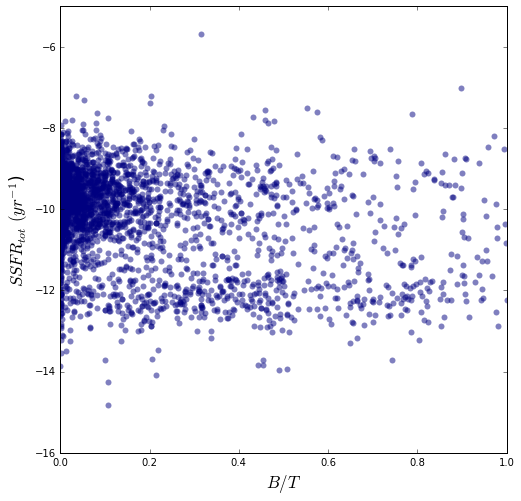

In [141]:
#SSFR_TOT vs. bulge frac
MCplot(bulge_frac, SSFR_TOT, '$B/T$','$SSFR_{tot} \ (yr^{-1}$)', fname = 'SSFR_TOT vs B_FRAC', ymin = -16, ymax = -5)

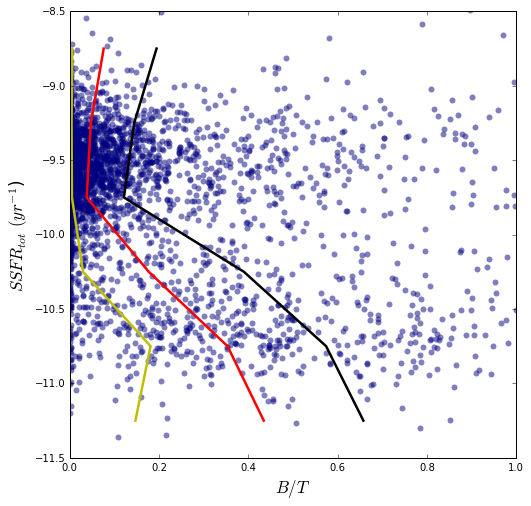

In [16]:
#SSFR_TOT vs. bulge frac zoomed in

x25, x50, x75, yplot = binnedplot(bulge_frac, SSFR_TOT, ymin = -11.5, ymax = -8.5, binn = 6)
MCplot(bulge_frac, SSFR_TOT, '$B/T$','$SSFR_{tot} \ (yr^{-1}$)',fname = 'SSFR_TOT vs B_FRAC ZOOM', 
       ymin = -11.5, ymax = -8.5, bins = 'yes' )

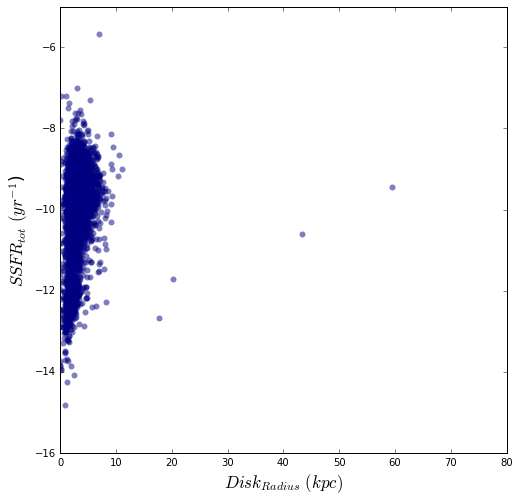

In [13]:
#SSFR_TOT vs. Disk Radius
MCplot(disk_kpc, SSFR_TOT, '$Disk_{Radius} \ (kpc)$','$SSFR_{tot} \ (yr^{-1}$)',fname = 'SSFR_TOT vs DISK_RE', ymin = -16, ymax = -5, xmax = 80)

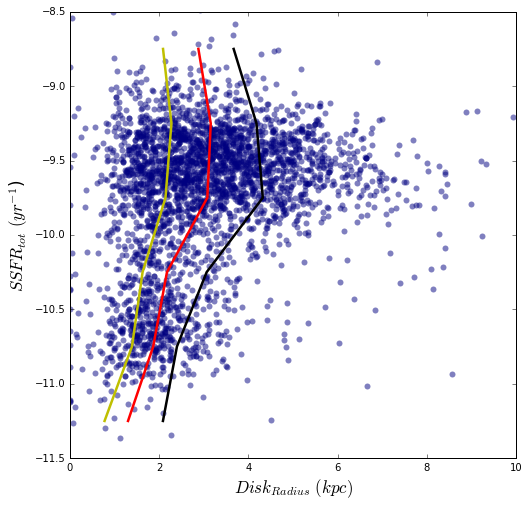

In [17]:
#SSFR_TOT vs. Disk Radius zoomed in 
x25, x50, x75, yplot = binnedplot(disk_kpc, SSFR_TOT, ymin = -11.5, ymax = -8.5, binn = 6)
MCplot(disk_kpc, SSFR_TOT, '$Disk_{Radius} \ (kpc)$','$SSFR_{tot} \ (yr^{-1}$)', 
       fname = 'SSFR_TOT vs DISK_RE ZOOM', 
       ymin = -11.5, ymax = -8.5, xmax = 10, bins = 'yes')

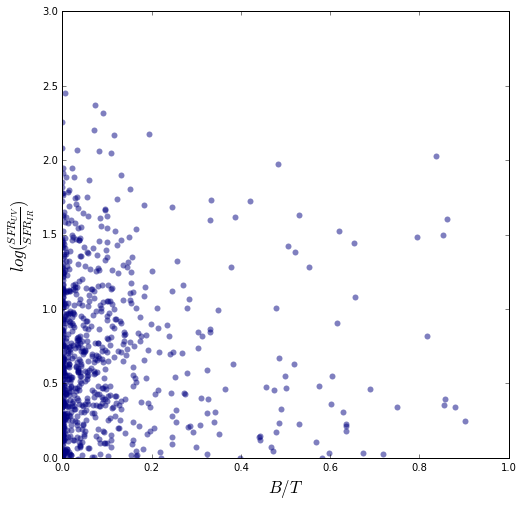

In [147]:
yy = np.log(SFR_UV/SFR_IR)
MCplot(bulge_frac, yy, 
       '$B/T$', r'$log(\frac{SFR_{UV}}{SFR_{IR}})$', fname = 'SSFR_UV_IR vs B_FRAC',
       ymin = 0, ymax = 3)
 #$log\frac{SFRUV}{SFRIR}$'

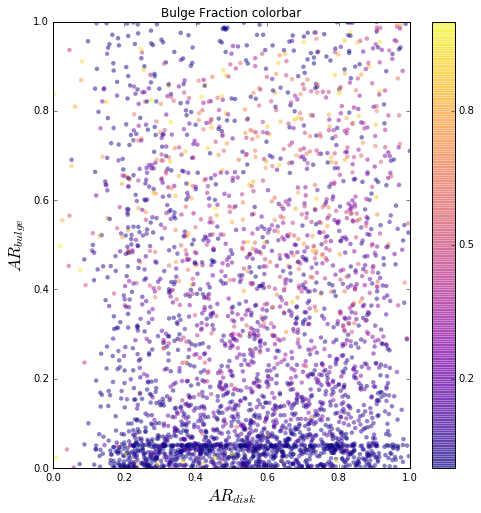

In [40]:
#axis ratio bulge vs axis ratio disk
MCplot(ba_ratiod, ba_ratiob, '$AR_{disk}$', '$AR_{bulge}$', 
       fname = 'AR_DISK vs AR_BULGE',
      xmin = 0, xmax = 1, ymin = 0, ymax = 1, mapc = 'yes')

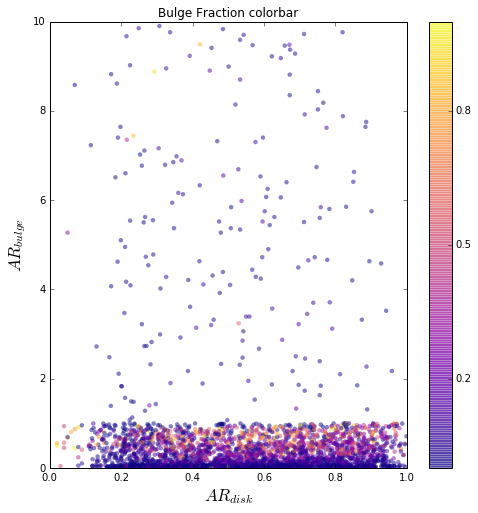

In [178]:
#axis ratio bulge vs axis ratio ZOOM
MCplot(ba_ratiod, ba_ratiob, '$AR_{disk}$', '$AR_{bulge}$', 
       fname = 'AR_DISK vs AR_BULGE ZOOM',
      xmin = 0, xmax = 1, ymin = 0, ymax = 10, mapc = 'yes')

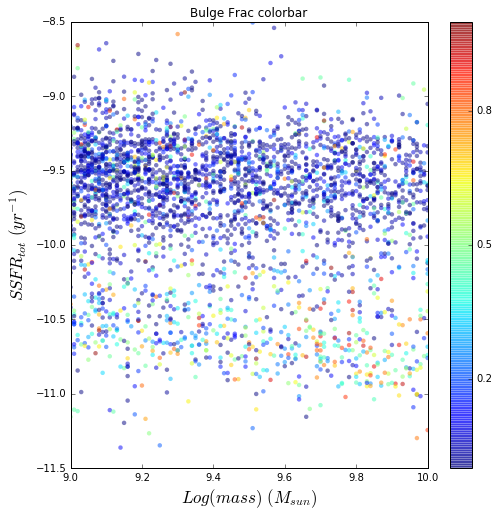

In [26]:
MCplot(LMASS, SSFR_TOT, '$Log(mass) \ (M_{sun})$', '$SSFR_{tot} \ (yr^{-1})$', 
       fname = 'SSFR vs. LMASS',
      xmin = 9, xmax = 10, ymin = -11.5, ymax = -8.5, mapc = 'yes', colorscale = bulge_frac)

In [11]:
#two bin mass plot
m1 = np.where(LMASS <= 9.5)
m2 = np.where(LMASS > 9.5)
b1 = np.array(bulge_frac)[m1]
b2 = np.array(bulge_frac)[m2]


d1 = np.array(disk_kpc)[m1]
d2 = np.array(disk_kpc)[m2]
s1 = np.array(SSFR_TOT)[m1]
s2 = np.array(SSFR_TOT)[m2]

In [12]:
x251, x501, x751, yplot1 = binnedplot(b1, s1, ymin = -11.5, ymax = -8.5, binn = 6)
x252, x502, x752, yplot2 = binnedplot(b2, s2, ymin = -11.5, ymax = -8.5, binn = 16)

x251d, x501d, x75d1, yplot1d = binnedplot(d1, s1, ymin = -11.5, ymax = -8.5, binn = 6)
x252d, x502d, x752d, yplot2d = binnedplot(d2, s2, ymin = -11.5, ymax = -8.5, binn = 16)

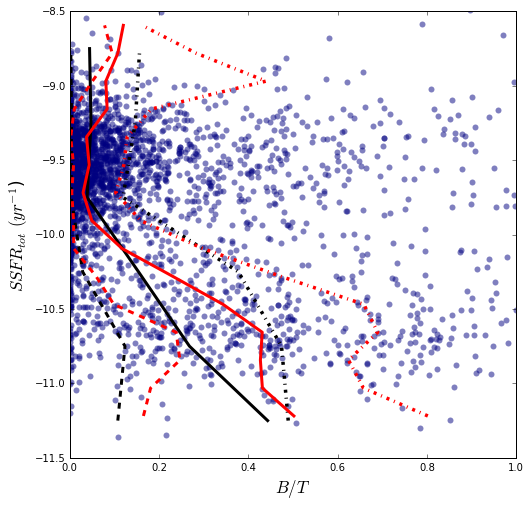

In [35]:
fig, ax = plt.subplots()
x251, x501, x751, yplot1 = binnedplot(b1, s1, ymin = -11.5, ymax = -8.5, binn = 6)
x252, x502, x752, yplot2 = binnedplot(b2, s2, ymin = -11.5, ymax = -8.5, binn = 16)
MCplot_2(b1, s1, '$B/T$','$SSFR_{tot} \ (yr^{-1}$)',fname = 'SSFR_TOT vs B_FRAC ZOOM', 
       ymin = -11.5, ymax = -8.5, bins = 'yes' )
ax.plot(b2, s2, linewidth = 0, alpha = 0.5, color = 'navy', marker = 'o', mew = 0)
bin_stat(x251, x501, x751, yplot1,x252, x502, x752, yplot2, 'Two Mass Bins SSFR vs. Bulge Frac v.2')

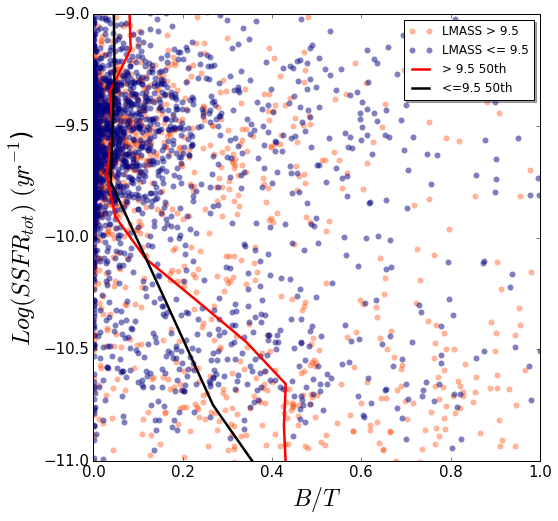

In [16]:
fig, ax = plt.subplots()

ax.plot(b2, s2, linewidth = 0, alpha = 0.4, color = 'orangered', marker = 'o', mew = 0)
MCplot_2(b1, s1, '$B/T$','$Log(SSFR_{tot}) \ (yr^{-1}$)',fname = 'aastex_test', 
       ymin = -11, ymax = -9, bins = 'yes')

ax.plot(x502, yplot2, 'red', alpha = 1, ms = 3, mew = 3, linewidth = 2.5, ls = '-')
ax.plot(x501, yplot1, 'k', alpha = 1, ms = 3, mew = 3, linewidth = 2.5, ls = '-')
legend = ax.legend(("LMASS > 9.5", "LMASS <= 9.5", '> 9.5 50th', '<=9.5 50th'),loc='upper right', shadow=True)
fname = '2_mass_bins_ssfr2'
ax.tick_params(axis='both', which='major', labelsize=15)
#plt.savefig('/Users/Nick/IS/Galfit/Plots/%s.pdf' %fname ,bbox_inches='tight')
plt.savefig('/Users/Nick/IS/AASTex/images/%s.pdf' %fname ,bbox_inches='tight')

In [20]:
#math with distributions 
from scipy import stats
stats.sem(b2, axis=None, ddof=0)


0.0070248980201687034

In [87]:
xx1 = s1 < (-10.0)
xx2 = s2 < (-10.0)
b1 = pd.Series(b1)
bb1 = b1[xx1]
b2 = pd.Series(b2)
bb2 = b2[xx2]
print np.median(bb2) - np.median(bb1)
print .11/(np.median(bb2))

0.11739085224
0.338266529761


In [86]:
xx3 = SSFR_TOT < (-10.0)
bulge_frac3 = pd.Series(bulge_frac3)
bulge_frac = pd.Series(bulge_frac)
print np.median(bulge_frac3[xx3])
print np.median(bulge_frac[xx3]) 

0.337804218413
0.275511593353


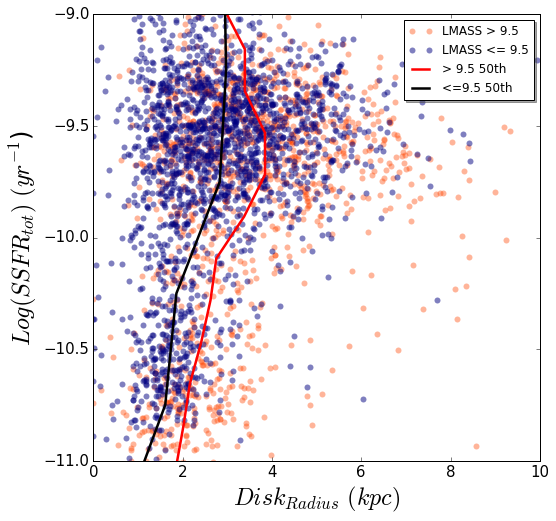

In [88]:
fig, ax = plt.subplots()

ax.plot(d2, s2, linewidth = 0, alpha = 0.4, color = 'orangered', marker = 'o', mew = 0)
MCplot_2(d1, s1, '$Disk_{Radius} \ (kpc)$','$Log(SSFR_{tot}) \ (yr^{-1}$)',fname = 'aas', 
       ymin = -11, ymax = -9, bins = 'yes')
ax.set_xlim(0,10)
ax.plot(x502d, yplot2d, 'red', alpha = 1, ms = 3, mew = 3, linewidth = 2.5, ls = '-')
ax.plot(x501d, yplot1d, 'k', alpha = 1, ms = 3, mew = 3, linewidth = 2.5, ls = '-')
legend = ax.legend(("LMASS > 9.5", "LMASS <= 9.5", '> 9.5 50th', '<=9.5 50th'),loc='upper right', shadow=True)
fname = '2_mass_bins_ssfr_disk2'
ax.tick_params(axis='both', which='major', labelsize=15)
#plt.savefig('/Users/Nick/IS/Galfit/Plots/%s.pdf' %fname ,bbox_inches='tight')
plt.savefig('/Users/Nick/IS/AASTex/images/%s.pdf' %fname ,bbox_inches='tight')

In [20]:
(np.mean(d2)- np.mean(d1))/np.mean(d1)
(np.mean(d2)- np.mean(d1))
np.median(d1)

2.5467874717900001

In [7]:
#plots for failures
dsboolbad = dsbool[dsbool==False]
badindex = dsboolbad.index.tolist()


#full lists
LMASS0 = ds['LMASS']
SFR_TOT0 = ds['SFR_tot']
U_V = ds['UmV']
V_J = ds['VmJ']
SSFR_TOT0 = np.log(SFR_TOT0) - LMASS0

In [8]:
dsbool2 = []
for ii in dsbool:
    if ii == False:
        dsbool2.append(True)
    else:
        dsbool2.append(False)
print len(U_V[dsbool2])

290


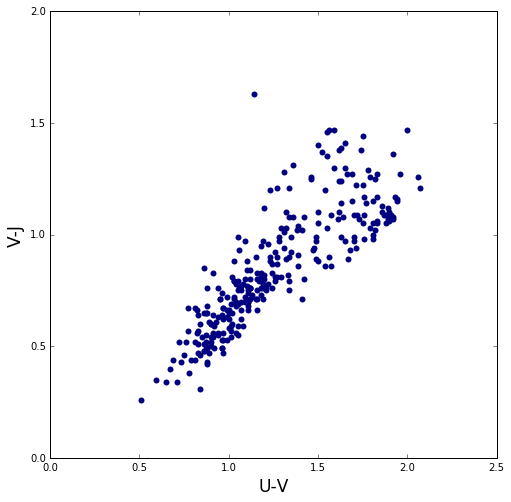

In [12]:
MCplot(U_V[badindex], V_J[badindex], 'U-V', 'V-J', 
      fname = 'Failures - UV vs. VJ v.2', xmin = 0, xmax = 2.5, ymin = 0, ymax = 2)

In [9]:
# selecting Quiescent galaxies and star forming galaxies using a color cutoff
UV_coords=np.array([1.3,2.01])
VJ_coords=np.array([0.693,1.5])
jj_qg=( (ds['z_peak']>=0.) & (ds['z_peak']<1.0) & 
(ds['UmV']>UV_coords[0]) & (ds['VmJ']<VJ_coords[1]) & 
(ds['UmV']>np.poly1d(np.polyfit(VJ_coords,UV_coords,1))(ds['VmJ']) 
) )
print len(jj_qg)
#selecting SFG
jj_sfg=( (ds['z_peak']>=0.) & (ds['z_peak']<1.0) & 
(ds['UmV']<UV_coords[0]) | (ds['VmJ']>VJ_coords[1]) | 
(ds['UmV']<np.poly1d(np.polyfit(VJ_coords,UV_coords,1))(ds['VmJ']) 
) )

y1 = U_V[dsbool2 &jj_qg]
y2 = U_V[dsbool2 & jj_sfg]

x1 = V_J[dsbool2 & jj_qg]
x2 = V_J[dsbool2 & jj_sfg]
print len(y1)

3372
55


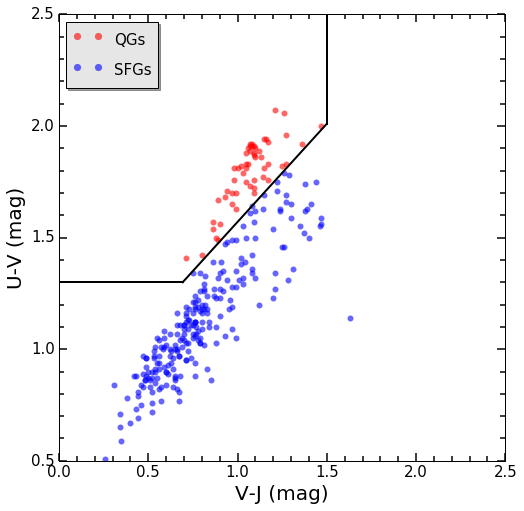

In [11]:
plt.figure(figsize=(8,8))

#vmjQG = ds2['VmJ'][jj_qg]
#umvQG = ds2['UmV'][jj_qg]

#vmjSFG = ds2['VmJ'][jj_sfg]
#umvSFG = ds2['UmV'][jj_sfg]

plotQG = plt.plot(x1, y1, "ro", alpha = .6, mew = 0)
plotSFG = plt.plot(x2, y2, "bo", alpha = .6, mew = 0)
# give plot a title
#plt.title("U-V Against V-J (failures)", fontsize = 24)
# make axis labels
plt.xlabel("V-J (mag)", fontsize = 20)
plt.ylabel("U-V (mag)", fontsize = 20)
legend = plt.legend(("QGs", "SFGs"),loc='upper left', shadow=True, handleheight = 2.0, handlelength = 2.0, fontsize = 15, 
                   markerscale = 1.2)
plt.xlim(0,2.5)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.plot([0, 0.693], [1.3, 1.3], color='k', linestyle='-', linewidth=2)
plt.plot([0.693, 1.5], [1.3, 2.01], color='k', linestyle='-', linewidth=2)
plt.plot([1.5, 1.5], [2.01, 2.5], color='k', linestyle='-', linewidth=2)

plt.minorticks_on()
plt.tick_params(axis='both',which='minor',length=5,width=1.5,labelsize=15)
plt.tick_params(axis='both',which='major',length=8,width=1.5,labelsize=15)
plt.savefig('/Users/Nick/IS/AASTex/images/failure_color.pdf', bbox_inches = 'tight')
#plt.savefig('/Users/Nick/IS/Galfit/Plots/uv_vj.pdf', bbox_inches='tight')

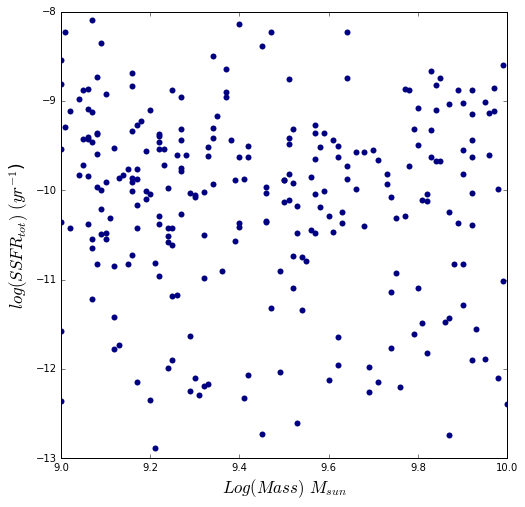

In [51]:
MCplot(LMASS[badindex], SSFR_TOT0[badindex], '$Log(Mass) \ M_{sun}$', '$log(SSFR_{tot}) \ (yr^{-1}$)', 
      fname = 'Failures_SSFR_TOT_vs_LMASS', xmin = 9, xmax = 10, ymin = -13, ymax = -8)

In [107]:
#testing additional binning
# figuring out how the postage stamp plots work
xaxis = bulge_frac
x_range = max(xaxis) - min(xaxis)
yaxis = SSFR_TOT
yrange = max(yaxis) - min(yaxis)
ya = np.arange(min(yaxis),max(yaxis),float(yrange)/10.0,float)
xa = np.arange(min(xaxis),max(xaxis),float(xrange)/10.0,float)

In [36]:
gs = lambda xte,yte: (np.abs(xaxis-xte)<x_range/20.0)&(np.abs(yaxis-yte)<yrange/20.0)

In [78]:
good_seeds = [np.nonzero(gs(xte,yte))[0][np.random.randint(0,sum(gs(xte,yte))-1)] 
              for yte in ya for xte in xa if sum(gs(xte,yte))>2]

In [106]:
index = []
for yte in ya:
    for xte in xa:
        if sum(gs(xte,yte))>2:
            xxx = np.nonzero(gs(xte, yte))[0][np.random.randint(0,sum(gs(xte,yte)))]
            index.append(xxx)

In [8]:
def binnedplot2(xdata, ydata, ymin, ymax, binn = 11):
    x25, y25, z25 = bin25 = binned_statistic(ydata, xdata, statistic=perc, bins=binn, range = (ymin,ymax))
    x50, y50, z50 = bin25 = binned_statistic(ydata, xdata, statistic=perc3, bins=binn, range = (ymin, ymax))
    x75, y75, z75 = bin25 = binned_statistic(ydata, xdata, statistic=perc2, bins=binn, range = (ymin,ymax))

    yplot = (y25[1]-y25[0])/2 + y25[0:binn]
    return x25, x50, x75, yplot


In [15]:
x25, x50, x75, yplot = binnedplot2(bulge_frac, SSFR_TOT, ymin = -11.5, ymax = -8.5, binn = 6)
x252, x502, x752, yplot2 = binnedplot2(disk_kpc, SSFR_TOT, ymin = -11.5, ymax = -8.5, binn = 6)

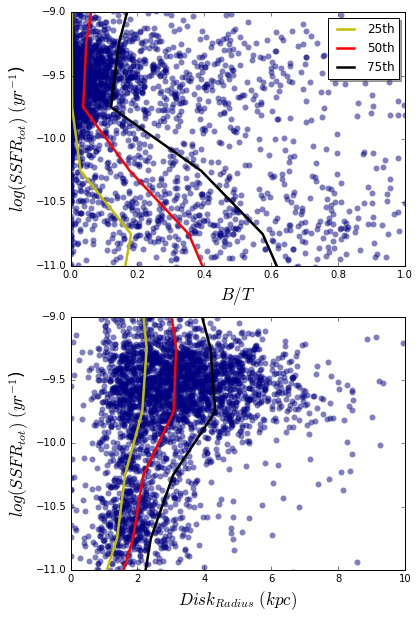

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, sharey=True)
fig.set_size_inches(6,10)

fname = 'bt_radius_ssfr2'
ax1.set_xlabel('$B/T$', fontsize = 17)
ax1.set_ylabel('$log(SSFR_{tot}) \ (yr^{-1}$)', fontsize = 17)
ax1.set_ylim(-11,-9)
ax1.set_xlim(0,1)
ax1.plot(bulge_frac, SSFR_TOT, linewidth = 0, alpha = 0.5, color = 'navy', marker = 'o', mew = 0, label='_nolegend_')
ax1.plot(x25,yplot, 'y', alpha = 1, ms = 3, mew = 3, linewidth = 2.5)
ax1.plot(x50,yplot, 'r', alpha = 1, ms = 3, mew = 3, linewidth = 2.5)
ax1.plot(x75, yplot, 'k', alpha = 1, ms = 3, mew = 3, linewidth = 2.5)

ax2.set_xlabel('$Disk_{Radius} \ (kpc)$', fontsize = 17)
ax2.set_ylabel('$log(SSFR_{tot}) \ (yr^{-1}$)', fontsize = 17)
ax2.set_ylim(-11,-9)
ax2.set_xlim(0,10)
ax2.plot(disk_kpc, SSFR_TOT, linewidth = 0, alpha = 0.5, color = 'navy', marker = 'o', mew = 0)
ax2.plot(x252,yplot2, 'y', alpha = 1, ms = 3, mew = 3, linewidth = 2.5)
ax2.plot(x502,yplot2, 'r', alpha = 1, ms = 3, mew = 3, linewidth = 2.5)
ax2.plot(x752, yplot2, 'k', alpha = 1, ms = 3, mew = 3, linewidth = 2.5)
legend = ax1.legend(("25th", "50th", '75th'),loc='upper right', shadow=True)
fig.subplots_adjust(wspace=0.1)
plt.savefig('/Users/Nick/IS/AASTex/images/%s.pdf' %fname ,bbox_inches='tight')
plt.show()
    